<a href="https://colab.research.google.com/github/easoplee/spine_segmentation/blob/main/lumbar_spine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lumbar Spine Bone (L1-S1) Segmentation
- dataset can be accessed from: https://data.mendeley.com/datasets/k3b363f3vz/2

### Import necessary packages

In [1]:
#pip install packages

!pip install itk
!pip install itkwidgets
!pip install pydicom
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#import necessary packages

import pathlib as Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence 
import torch.nn.functional as F
import os
import pydicom as dicom
import matplotlib.patches as mpatches
import matplotlib.animation as animation
import matplotlib.image as img
import zipfile
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import time
from PIL import Image

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
class config:
  BATCH_SIZE = 20
  INPUT_IMAGE_HEIGHT = 224
  INPUT_IMAGE_WIDTH = 224
  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
  PIN_MEMORY = True if DEVICE == "cuda" else False
  LEARNING_RATE = 3e-5
  NUM_EPOCHS = 10
  MODEL_PATH = "/output/model.pth"
  PLOT_PATH = "/output/plot.png"

## Download the dataset from google drive

In [4]:
# mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#unzip the zip file
!unzip -u "/content/drive/MyDrive/lumbar_mid_sagittal.zip" -d "/content/drive/MyDrive/"

Archive:  /content/drive/MyDrive/lumbar_mid_sagittal.zip


In [6]:
#download the image and ground truth mask
image_dir = '/content/drive/MyDrive/lumbar_mid_sagittal/Images/'
label_dir = '/content/drive/MyDrive/lumbar_mid_sagittal/Pseudo_Colored_Ground_Truth_Images'

#print out the number of images and labels
print(f'Total number of MRI scans: {len(os.listdir(image_dir))}')
print(f'Total number of MRI labels: {len(os.listdir(label_dir))}')

Total number of MRI scans: 514
Total number of MRI labels: 514


In [7]:
DIR_SIZE = len(os.listdir(image_dir))
print(sorted(os.listdir(image_dir)))

['T1_0001_S8.png', 'T1_0002_S8.png', 'T1_0003_S8.png', 'T1_0004_S7.png', 'T1_0005_S8.png', 'T1_0006_S8.png', 'T1_0007_S8.png', 'T1_0008_S7.png', 'T1_0009_S7.png', 'T1_0010_S8.png', 'T1_0011_S8.png', 'T1_0012_S8.png', 'T1_0013_S8.png', 'T1_0014_S8.png', 'T1_0015_S8.png', 'T1_0016_S8.png', 'T1_0017_S8.png', 'T1_0019_S8.png', 'T1_0020_S15.png', 'T1_0021_S8.png', 'T1_0022_S8.png', 'T1_0023_S8.png', 'T1_0024_S7.png', 'T1_0025_S8.png', 'T1_0026_S8.png', 'T1_0027_S14.png', 'T1_0029_S7.png', 'T1_0030_S8.png', 'T1_0031_S8.png', 'T1_0032_S8.png', 'T1_0033_S8.png', 'T1_0034_S8.png', 'T1_0035_S8.png', 'T1_0036_S8.png', 'T1_0037_S7.png', 'T1_0038_S8.png', 'T1_0039_S8.png', 'T1_0040_S8.png', 'T1_0041_S8.png', 'T1_0042_S15.png', 'T1_0043_S8.png', 'T1_0044_S8.png', 'T1_0046_S8.png', 'T1_0047_S8.png', 'T1_0048_S8.png', 'T1_0050_S8.png', 'T1_0051_S8.png', 'T1_0052_S8.png', 'T1_0053_S8.png', 'T1_0055_S15.png', 'T1_0056_S8.png', 'T1_0057_S8.png', 'T1_0058_S8.png', 'T1_0060_S8.png', 'T1_0061_S8.png', 'T1_0

## Visualize an example image and label



In [8]:
#parameters: img_dir -> string that specifies where the images are stored at; label_dir -> similar

def view_img_label(img_dir, label_dir):
  dir_size = DIR_SIZE
  #rand_int = np.random.randint(0, dir_size-1)
  rand_int=0
  ex_img_dir = os.path.join(image_dir, sorted(os.listdir(image_dir))[rand_int])
  print(ex_img_dir)
  ex_img = cv2.imread(ex_img_dir)
  ex_label_dir = os.path.join(label_dir, sorted(os.listdir(label_dir))[rand_int])
  print(ex_label_dir)
  ex_label = cv2.imread(ex_label_dir)

  #cv2_imshow(ex_img)
  #cv2_imshow(ex_label)
  return ex_img, ex_label, ex_img_dir, ex_label_dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipympl 0.9.1 requires matplotlib<4,>=3.4.0, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


/content/drive/MyDrive/lumbar_mid_sagittal/Images/T1_0001_S8.png
/content/drive/MyDrive/lumbar_mid_sagittal/Pseudo_Colored_Ground_Truth_Images/T1_0001_S8.png
image shape: (320, 320, 3)
label shape: (320, 320, 3)


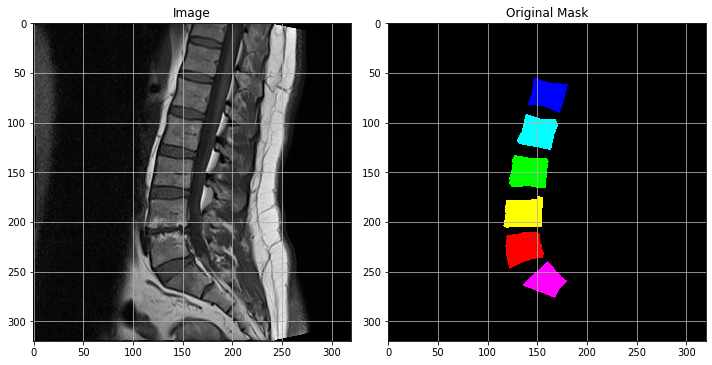

In [9]:
!pip install matplotlib==3.1.3
ex_img, ex_label, ex_img_dir, ex_label_dir = view_img_label(image_dir, label_dir)
print(f'image shape: {ex_img.shape}')
print(f'label shape: {ex_label.shape}')
#print(ex_img)
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
# plot the original image, its mask, and the predicted mask
ax[0].imshow(ex_img)
ax[1].imshow(ex_label)

# set the titles of the subplots
ax[0].set_title("Image")
ax[1].set_title("Original Mask")
ax[0].grid(True)
ax[1].grid(True)

# set the layout of the figure and display it
figure.tight_layout()
figure.show()

In [10]:
print(ex_img)

[[[ 7  7  7]
  [ 5  5  5]
  [ 4  4  4]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 9  9  9]
  [ 1  1  1]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[16 16 16]
  [32 32 32]
  [37 37 37]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 ...

 [[ 2  2  2]
  [ 8  8  8]
  [ 9  9  9]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 1  1  1]
  [ 2  2  2]
  [ 1  1  1]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 2  2  2]
  [ 2  2  2]
  [ 2  2  2]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]


## Data formatting
- mask shape: [height x width] and contain class indices for each pixel location in the range (0, nb_classes=7)

In [11]:
#TODO: print out all the unique color labels

#flatten out the image -> [[R,G,B]*(width*height)]
print(np.unique(ex_label))
print(ex_label.shape[0])
print(ex_label[3,3])

def flatten_img(img):
  width = img.shape[0]
  height = img.shape[1]

  temp = []

  for w in range(width):
    for h in range(height):
      temp.append(img[w, h])
  return temp

ex_label_flatten = flatten_img(ex_label)

unique_data = [list(x) for x in set(tuple(x) for x in ex_label_flatten)]
print(unique_data)

#[[0, 255, 255], [255, 255, 0], [0, 0, 255], [255, 0, 0], [255, 0, 255], [0, 0, 0], [0, 255, 0]]

[  0 255]
320
[0 0 0]
[[0, 255, 255], [255, 255, 0], [0, 0, 255], [255, 0, 0], [255, 0, 255], [0, 0, 0], [0, 255, 0]]


In [12]:
#given an color-coded mask, format in such that each pixel location in the range contains an integer from 0 to 7
colorToClass = {
    (0, 0, 0) : 'background',
    (255, 255, 0) : 'L1',
    (255, 0, 0) : 'L2',
    (0, 255, 0) : 'L3',
    (0, 255, 255) : 'L4',
    (0, 0, 255) : 'L5',
    (255, 0, 255) : 'S1'
}

classToInt = {
    'background': 0,
    'L1': 1,
    'L2': 2,
    'L3': 3,
    'L4': 4,
    'L5': 5,
    'S1': 6
}

IntToColor = {
    0: (0, 0, 0),
    1: (255, 255, 0),
    2: (255, 0, 0),
    3: (0, 255, 0),
    4: (0, 255, 255),
    5: (0, 0, 255),
    6: (255, 0, 255)
}

def RGBtoInt(label_img):
  temp = np.zeros((label_img.shape[0], label_img.shape[1]))
  for i in range(label_img.shape[0]):
    for j in range(label_img.shape[1]):
      temp[i, j] = int(classToInt.get(colorToClass.get(tuple(label_img[i, j]))))
  return temp

#test RGBtoInt function
#print(ex_label)
test_label_Int = RGBtoInt(ex_label)
print(test_label_Int)
print(np.unique(test_label_Int))
#print(torch.FloatTensor(test_label_Int[100]))
print(test_label_Int[0,0])
non_background = 0
for i in range(test_label_Int.shape[0]):
  for j in range(test_label_Int.shape[1]):
    if int(test_label_Int[i,j]) == 0:
      non_background += 1

total_pixels = test_label_Int.shape[0] * test_label_Int.shape[1]
print(f'Percentage of background: {non_background/total_pixels*100}%')


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 2. 3. 4. 5. 6.]
0.0
Percentage of background: 94.216796875%


## Resize to (config.HEIGHT, config.WIDTH)


In [13]:
def resize_img(img, img_stack=1):
  width = config.INPUT_IMAGE_WIDTH #224
  height = config.INPUT_IMAGE_HEIGHT #224
  img_stack_sm = np.zeros((width, height, img_stack)) #empty list of (3, 224, 224)

  if img_stack==1:
    img_stack_sm = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
  else:
    for idx in range(img_stack):
      img2 = img[:, :, idx]
      #print(img2.shape)
      img_sm = cv2.resize(img2, (width, height), interpolation=cv2.INTER_NEAREST)
      #print(img_sm.shape)
      img_stack_sm[:, :, idx] = img_sm
  return img_stack_sm

#print(ex_img)
test_resize_img= resize_img(ex_img, 3)
#print(test_resize_img)
#print(np.unique(test_resize_img))

## Load all data into SpineData

In [14]:
class spineData(Dataset):
  def __init__(self, path, label_path, transform):
    self.files = sorted(os.listdir(path))
    self.labels = sorted(os.listdir(label_path))
    self.transform = transform
    self.path = path
    self.labelpath = label_path

  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    filename = os.path.join(self.path, self.files[index])
    #print(filename)
    tensor_image = cv2.imread(filename)
    tensor_image = cv2.resize(tensor_image, (config.INPUT_IMAGE_WIDTH, config.INPUT_IMAGE_HEIGHT))
    #print('img: ',image)
    #tensor_image = resize_img(image, 3)
    tensor_image = torch.Tensor(tensor_image/255)
    #plt.imshow(tensor_image)
    tensor_image = torch.permute(tensor_image, (2,0,1))
    #tensor_image = F.interpolate(tensor_image, size=(3, 224, 224), mode='bicubic', align_corners=False)

    label_filename = os.path.join(self.labelpath, self.labels[index])
    label = cv2.imread(label_filename)
    label = resize_img(RGBtoInt(label))
    #tensor_label = self.transform(label)
    tensor_label = torch.LongTensor(label)
    #tensor_label = F.interpolate(tensor_label, size=(224, 224), mode='bicubic', align_corners=False)

    return tensor_image, tensor_label

In [15]:
transform = transforms.ToTensor()
# define transformations
# transform = transforms.Compose([transforms.ToPILImage(),
#  	transforms.Resize((config.INPUT_IMAGE_HEIGHT,
# 		config.INPUT_IMAGE_WIDTH)),
# 	transforms.ToTensor()])
spine_dataset = spineData(image_dir, label_dir, transform)

In [16]:
#plt.imshow(spine_dataset[0][0])

print(np.unique(spine_dataset[0][1])) #resize with keeping new labels
print(spine_dataset[0][0].shape)
print(spine_dataset[0][1].shape)
print(len(spine_dataset))

[0 1 2 3 4 5 6]
torch.Size([3, 224, 224])
torch.Size([224, 224])
514


## Make train and val datasets, dataloaders

In [17]:
print(f'total size: {len(spine_dataset)}')
train_size = int(0.9 * len(spine_dataset))
val_size = len(spine_dataset) - train_size
print(f'train size: {train_size}\nvalidation size: {val_size}')
train, val = torch.utils.data.random_split(spine_dataset, [train_size, val_size])
print(len(train))
print(val[0][1].shape)

total size: 514
train size: 462
validation size: 52
462
torch.Size([224, 224])


In [18]:
train_dataloader = DataLoader(train, shuffle=True,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())

train_x, train_y = next(iter(train_dataloader))

print(f'train_x = shape: {train_x.shape}; type: {train_x.dtype}')
print(f'train_x = min: {train_x.min()}; max: {train_x.max()}')
#print(f'train_y = shape: {train_y.shape}; class: {train_y.unique()}; type: {train_y.dtype}')

val_dataloader = DataLoader(val, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())

val_x, val_y = next(iter(val_dataloader))
print(f'val_x = shape: {val_x.shape}')
print(f'val_y = shape: {val_y.shape}')

dataloaders = {
  'train': train_dataloader,
  'val': val_dataloader
}

print(len(train_dataloader))
print(len(val_dataloader))

train_x = shape: torch.Size([20, 3, 224, 224]); type: torch.float32
train_x = min: 0.0; max: 0.9960784316062927
val_x = shape: torch.Size([20, 3, 224, 224])
val_y = shape: torch.Size([20, 224, 224])
24
3


## 2D U-Net Architecture

In [19]:
import torchvision
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False, progress=True, num_classes=7, aux_loss=None)
model = model.to(config.DEVICE)
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [20]:
'''
import torch 
import torch.nn as nn
import torchvision.transforms.functional as TF 

class UNET(nn.Module):
    
    def __init__(self, in_channels=3, classes=1):
        super(UNET, self).__init__()
        self.layers = [in_channels, 64, 128, 256, 512, 1024]
        
        self.double_conv_downs = nn.ModuleList(
            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])
        
        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])
            
        self.double_conv_ups = nn.ModuleList(
        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])
        
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)

        
    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv
    
    def forward(self, x):
        # down layers
        concat_layers = []
        
        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)
        
        concat_layers = concat_layers[::-1]
        
        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])
            
            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)
            
        x = self.final_conv(x)
        
        return x 
'''

'\nimport torch \nimport torch.nn as nn\nimport torchvision.transforms.functional as TF \n\nclass UNET(nn.Module):\n    \n    def __init__(self, in_channels=3, classes=1):\n        super(UNET, self).__init__()\n        self.layers = [in_channels, 64, 128, 256, 512, 1024]\n        \n        self.double_conv_downs = nn.ModuleList(\n            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])\n        \n        self.up_trans = nn.ModuleList(\n            [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)\n             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])\n            \n        self.double_conv_ups = nn.ModuleList(\n        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])\n        \n        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)\n        \n        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)\n\n        \n    def __double_conv(self, in_c

In [21]:
#model = UNET(in_channels=3, classes=7).to(config.DEVICE)
#model

In [22]:
#summary(model, input_size=(3, 224, 224))

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()

# calculate steps per epoch for training and test set
trainSteps = len(train) // config.BATCH_SIZE
testSteps = len(val) // config.BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

print(trainSteps)

23


In [24]:
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
	# set the model in training mode
  model.train()
	# initialize the total training and validation loss
  totalTrainLoss = 0
  totalTestLoss = 0
	# loop over the training set
  for (i, (x, y)) in enumerate(train_dataloader):
		# send the input to the device
    (x, y) = (x.type(torch.cuda.FloatTensor).to(config.DEVICE), y.to(config.DEVICE))
		# perform a forward pass and calculate the training loss
    pred = model(x)
    pred = pred['out']
    print(pred.shape)
    loss = loss_function(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
		# add the loss to the total training loss so far
    totalTrainLoss += loss
	# switch off autograd
  with torch.no_grad():
		# set the model in evaluation mode
    model.eval()
		# loop over the validation set
    for (x, y) in val_dataloader:
			# send the input to the device
      (x, y) = (x.type(torch.cuda.FloatTensor).to(config.DEVICE), y.to(config.DEVICE))
			# make the predictions and calculate the validation loss
      pred = model(x)
      pred = pred['out']
      totalTestLoss += loss_function(pred, y)
	# calculate the average training and validation loss
  avgTrainLoss = totalTrainLoss / trainSteps
  avgTestLoss = totalTestLoss / testSteps
	# update our training history
  H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
  H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
  print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
  print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([2, 7, 224, 224])


 10%|█         | 1/10 [06:09<55:25, 369.45s/it]

[INFO] EPOCH: 1/10
Train loss: 1.802010, Test loss: 2.9254
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([2, 7, 224, 224])


 20%|██        | 2/10 [12:11<48:42, 365.30s/it]

[INFO] EPOCH: 2/10
Train loss: 1.268010, Test loss: 1.4133
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([2, 7, 224, 224])


 30%|███       | 3/10 [18:11<42:20, 362.93s/it]

[INFO] EPOCH: 3/10
Train loss: 0.949822, Test loss: 0.9792
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([2, 7, 224, 224])


 40%|████      | 4/10 [24:14<36:16, 362.71s/it]

[INFO] EPOCH: 4/10
Train loss: 0.781542, Test loss: 1.0621
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([2, 7, 224, 224])


 50%|█████     | 5/10 [30:11<30:04, 360.83s/it]

[INFO] EPOCH: 5/10
Train loss: 0.702953, Test loss: 1.0692
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([2, 7, 224, 224])


 60%|██████    | 6/10 [36:14<24:05, 361.42s/it]

[INFO] EPOCH: 6/10
Train loss: 0.633527, Test loss: 0.8644
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([2, 7, 224, 224])


 70%|███████   | 7/10 [42:10<17:59, 359.67s/it]

[INFO] EPOCH: 7/10
Train loss: 0.577878, Test loss: 0.7384
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([2, 7, 224, 224])


 80%|████████  | 8/10 [47:59<11:52, 356.36s/it]

[INFO] EPOCH: 8/10
Train loss: 0.523218, Test loss: 0.6688
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([2, 7, 224, 224])


 90%|█████████ | 9/10 [53:52<05:55, 355.18s/it]

[INFO] EPOCH: 9/10
Train loss: 0.482649, Test loss: 0.6454
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([20, 7, 224, 224])
torch.Size([2, 7, 224, 224])


100%|██████████| 10/10 [59:43<00:00, 358.38s/it]

[INFO] EPOCH: 10/10
Train loss: 0.446793, Test loss: 0.5825
[INFO] total time taken to train the model: 3583.78s


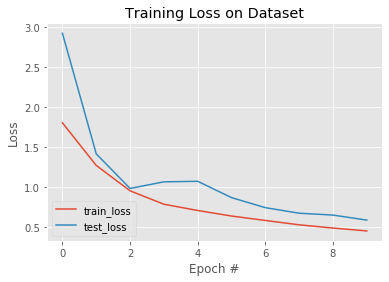

In [25]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
#plt.savefig(config.PLOT_PATH)
# serialize the model to disk
#torch.save(model, config.MODEL_PATH)

In [26]:
def diceCoefficient(y_true, y_pred):
    intersection = torch.logical_and(y_true, y_pred)
    return (2*torch.sum(intersection)/(torch.sum(y_true)+torch.sum(y_pred))).item()
def falsepos(y_true, y_pred): #false positive rate = FP/(TN+FP)
    intersection = torch.logical_and(y_true, y_pred)
    FP = (torch.sum(y_pred) - torch.sum(intersection))
    actual_neg = config.INPUT_IMAGE_HEIGHT*config.INPUT_IMAGE_WIDTH - torch.sum(y_true)
    return (FP/actual_neg).item()
def falseneg(y_true, y_pred): #false negative rate: 
    intersection = torch.sum(torch.logical_and(y_true, y_pred))
    FN = torch.sum(y_true) - intersection
    actual_pos = torch.sum(y_true)
    return (FN/actual_pos).item()
def jaccard_index(y_true, y_pred):
    intersection = torch.logical_and(y_true, y_pred)
    union = torch.logical_or(y_true, y_pred)
    return torch.sum(intersection)/torch.sum(union)

In [27]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [28]:
IntToColor = {
    0: 'background',
    1: 'L1',
    2: 'L2',
    3: 'L3',
    4: 'L4',
    5: 'L5',
    6: 'S1'
}

classToColor = {
    'background': (0, 0, 0),
    'L1': (255, 255, 0),
    'L2': (255, 0, 0),
    'L3': (0, 255, 0),
    'L4': (0, 255, 255),
    'L5': (0, 0, 255),
    'S1': (255, 0, 255)
}

def IntToRGB(img):
  temp = np.zeros((img.shape[0], img.shape[1], 3))
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      temp[i, j, :] = list(classToColor.get(IntToColor.get(img[i,j].item())))
  return temp

(320, 320, 3)
(224, 224, 3)
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


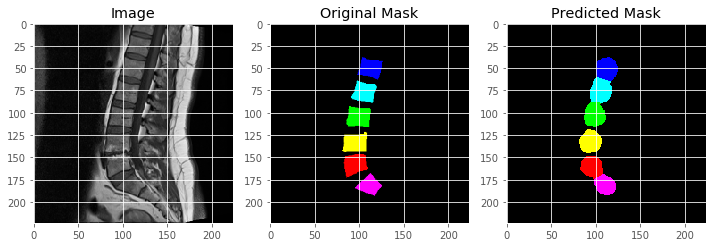

In [29]:
from skimage import io
from skimage import color
from skimage import segmentation

with torch.no_grad():
  model.eval()
  image = cv2.imread(ex_img_dir)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = image.astype("float32") / 255.0
  print(image.shape)
  image = cv2.resize(image, (config.INPUT_IMAGE_WIDTH, config.INPUT_IMAGE_HEIGHT))
  print(image.shape)
  orig = image.copy()

  gtMask = cv2.imread(ex_label_dir)
  gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_WIDTH, config.INPUT_IMAGE_HEIGHT))
  print(gtMask)
  gt_Mask_t = torch.tensor(gtMask)

  image = np.transpose(image, (2, 0, 1))
  image = np.expand_dims(image, 0)
  image = torch.from_numpy(image).to(config.DEVICE)
  print(image.shape)
  # make the prediction, pass the results through the sigmoid
  # function, and convert the result to a NumPy array
  predMask = model(image)
  predMask = predMask['out']
  #print((predMask.detach().cpu())[:,0,:,120])
  #print((predMask.detach().cpu())[:,1,:,120])
  #print(predMask.shape)
  predMask = torch.argmax(predMask, 1).detach().cpu().squeeze()
  predMask = IntToRGB(predMask)
  #print(classToColor.get(IntToColor.get(predMask[2,5].item())))
  #print(predMask[2,5].item())
  #predMask = torch.sigmoid(predMask)
  #predMask = predMask.cpu().numpy()
  # filter out the weak predictions and convert them to integers
  # predMask = predMask.astype(np.uint8)
  # predMask = torch.tensor(predMask)
  # predMask = torch.argmax(predMask, dim=1)

  prepare_plot(orig, gtMask, predMask)

In [34]:
jaccard_index(gt_Mask_t, torch.Tensor(predMask)).item()

0.7260197401046753